Reference1 : https://www.kaggle.com/code/titericz/better-xgb-baseline <br>
Reference2 : https://www.kaggle.com/code/byungeunhwang/better-xgb-baseline-with-comments-added

# import & !pip

In [1]:
!pip install xgboost==1.7.3
!pip install category_encoders

  Using cached xgboost-1.7.3-py3-none-win_amd64.whl (89.1 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.1
    Uninstalling xgboost-1.7.1:
      Successfully uninstalled xgboost-1.7.1


In [2]:
import gc  # import the gc (garbage collection) module for memory management
import numpy as np  # import the NumPy library for scientific computing
import pandas as pd  # import the pandas library for data preprocessing and analysis
import xgboost as xgb  # import the xgboost library for gradient boosting
from tqdm.notebook import tqdm  # import the tqdm library for progress display

pd.set_option('display.max_columns', None)

# GoDaddy 데이터 불러오기

In [4]:
# for colab
# !pip install kaggle
# from google.colab import files
# files.upload();

In [7]:
# ls -1ha kaggle.json

In [9]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle
# !chmod 600  ~/.kaggle/kaggle.json

명령 구문이 올바르지 않습니다.
'cp'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'chmod'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [14]:
# for jupyter
# !copy "C:\Users\Taeyang\Desktop\kaggle\kaggle.json" .
# !kaggle config set -n path -v ".\kaggle.json"
# !kaggle config set -n path -v "C:\Users\Taeyang\Desktop\kaggle"

Traceback (most recent call last):
  File "C:\Users\Taeyang\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Taeyang\Anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Taeyang\Anaconda3\Scripts\kaggle.exe\__main__.py", line 4, in <module>
  File "C:\Users\Taeyang\Anaconda3\lib\site-packages\kaggle\__init__.py", line 23, in <module>
    api.authenticate()
  File "C:\Users\Taeyang\Anaconda3\lib\site-packages\kaggle\api\kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in C:\Users\Taeyang\.kaggle. Or use the environment method.


In [20]:
# for jupyter
import os
os.environ['KAGGLE_CONFIG_DIR'] = r'C:\Users\Taeyang\Desktop\kaggle'

In [22]:
!kaggle competitions list

ref                                                                               deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/nfl-player-contact-detection                  2023-03-01 23:59:00  Featured          $100,000        468           False  
https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting     2023-03-14 23:59:00  Featured           $60,000       1361            True  
https://www.kaggle.com/competitions/learning-equality-curriculum-recommendations  2023-03-14 23:59:00  Featured           $55,000        409            True  
https://www.kaggle.com/competitions/santa-2022                                    2023-01-17 23:59:00  Featured           $50,000        843           False  
https://www.kaggle.com/competitions/rsna-breas

In [23]:
!kaggle competitions download -c godaddy-microbusiness-density-forecasting


  0%|          | 0.00/1.74M [00:00<?, ?B/s]
100%|##########| 1.74M/1.74M [00:00<00:00, 45.2MB/s]


In [32]:
# for colab
# !ls
# !unzip /content/godaddy-microbusiness-density-forecasting

In [31]:
# for jupyter
# import zipfile
# with zipfile.ZipFile("godaddy-microbusiness-density-forecasting.zip","r") as zip_ref:
#     zip_ref.extractall()

In [30]:
ls

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 22A4-1D2C

 C:\Users\Taeyang\Desktop\kaggle\GoDaddy 디렉터리

2023-01-15  오후 05:57    <DIR>          .
2023-01-15  오후 05:57    <DIR>          ..
2023-01-15  오후 05:39    <DIR>          .ipynb_checkpoints
2023-01-15  오후 05:57           438,443 GoDaddy_2023_01_15_0_0_4.ipynb
2023-01-15  오후 05:54         1,819,703 godaddy-microbusiness-density-forecasting.zip
2023-01-14  오후 03:07    <DIR>          old_models
2023-01-15  오후 05:36    <DIR>          old_notebooks
2023-01-14  오후 03:07    <DIR>          old_submissions
2023-01-13  오후 07:15             1,041 README.md
               3개 파일           2,259,187 바이트
               6개 디렉터리  52,876,869,632 바이트 남음


# EDA & 전처리& 모델링 

## SMAPE 함수 작성

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

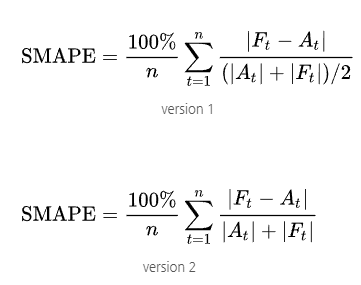

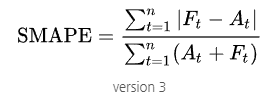

In [33]:
# 이 코드는 smape() 함수를 정의한다.
# 이 함수는 실제 값과 예측 값의 차이를 측정하는 함수이다.
# 이 함수의 인자로는 실제 값인 y_true 와 예측 값인 y_pred가 입력된다.
# smape() 함수는 입력받은 y_true 와 y_pred 값을 이용해서 실제 값과 예측 값의 차이를 측정하는 수치값을 계산한다.
# 이 수치값은 예측 값과 실제 값의 차이가 얼마나 커졌는지를 측정하는 지표인 SMAPE (Symmetric Mean Absolute Percentage Error) 지표이다.
def smape(y_true, y_pred):
    # create an array to store the SMAPE values
    smap = np.zeros(len(y_true))
    
    # calculate the numerator and denominator of the SMAPE formula
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    # find the indices of the elements that are not zero in both y_true and y_pred
    pos_ind = (y_true!=0)|(y_pred!=0)

    # calculate the SMAPE values for the elements at the indices
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    # return the mean of the SMAPE array
    return 100 * np.mean(smap)

def vsmape(y_true, y_pred):
    # create an array to store the SMAPE values
    smap = np.zeros(len(y_true))
    
    # calculate the numerator and denominator of the SMAPE formula
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    # find the indices of the elements that are not zero in both y_true and y_pred
    pos_ind = (y_true!=0)|(y_pred!=0)

    # calculate the SMAPE values for the elements at the indices
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    # return the SMAPE array
    return 100 * smap

In [34]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')
census = pd.read_csv('census_starter.csv')
print(train.shape, test.shape, sub.shape, census.shape)

(122265, 7) (25080, 3) (25080, 2) (3142, 26)


In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


In [36]:
train.head(1)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249


In [37]:
test.head(1)

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01


In [38]:
sub.head(1)

,row_id,microbusiness_density
0,1001_2022-11-01,3.817671


In [39]:
census.head(1)

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0


## 데이터 정보

**주석**<br>
county => (자치군,자치주,도시) <br>
microbusiness => (소상공인, 소규모사업자)<br>

**train.csv**

* 훈련 데이터 입니다.
* row_id - 행방향 ID 코드입니다.
* cfips - 연방 정보 처리 시스템을 사용하는 각 카운티의 고유 식별자입니다. 처음 두 자리는 주 FIPS 코드에 해당하며, 다음 3자리는 카운티를 나타냅니다.
* county_name - 카운티의 서면 이름입니다.
* state_name - 상태의 이름입니다.
* first_day_of_month - 월의 첫 번째 날의 날짜입니다.
* microbusiness_density - 해당 카운티의 18세 이상 인구 100명당 소상공인의 수이며 타겟 변수입니다. 밀도 계산에 사용되는 인구 수치는 매년 기초 인구 데이터를 제공하는 미국 인구조사국이 제공하는 업데이트 속도로 인해 2년씩 지연되고 있다.예를들어 2021년 밀도 수치는 2019년 인구 수치 등을 사용하여 계산된다.
* active - 카운티 내 활동중인 소상공인의 수. 테스트 세트에는 제공되지 않습니다.

**sample_submission.csv** 

* sample_submission파일은 올바른 제출을위해 제공됩니다. 이 파일은 대회 내내 변경되지 않습니다.
* row_id - 행방향 ID 코드입니다.
* microbusiness_density - 타겟 변수입니다.

**test.csv** 

* train을 통해 훈련된 모델을 적용시켜 타겟값을 예측해야합니다.
* row_id - 행방향 ID 코드입니다.
* cfips - 연방 정보 처리 시스템을 사용하는 각 카운티의 고유 식별자입니다. 처음 두 자리는 주 FIPS 코드에 해당하며, 다음 3자리는 카운티를 나타냅니다.
* first_day_of_month - 월의 첫 번째 날의 날짜입니다.

**relevened_test.csv** <br>
제출 기간 동안 공개 리더보드에는 최근 달의 데이터만 사용됩니다. 이보다 오래된 테스트 세트 데이터는 microbusiness 보고서의 일반적인 데이터 릴리스 주기에 따라 released_test.csv에 게시됩니다. **우리는 2월 중순에 relevened_test.csv 한 부를 발행할 예정입니다. 이 파일의 스키마는 train.csv와 일치합니다.**

**census_starter.csv** <br>
인구 조사국의 미국 공동체 조사(ACS)의 유용한 칼럼의 예:data.census.gov. 백분율 필드는 ACS에서 제공한 원시 카운트에서 파생되었습니다. 모든 분야는 주어진 소규모 비즈니스 데이터 업데이트가 발표된 시점에 어떤 정보를 이용할 수 있었는지를 맞추기 위해 2년의 시차를 두고 있다.

* pct_bb_[year] - 카운티에서 모든 유형의 광대역에 액세스할 수 있는 가구의 백분율. ACS 표 B28002: 가정 내 인터넷 가입의 존재 및 유형에서 파생되었다.
* cfips - CFIPS 코드입니다.
* pct_college_[year] - 4년제 대학 학위를 가진 25세 이상의 인구 비율입니다. ACS 표 S1501: 교육적 성취에서 파생되었습니다.
* pct_foreign_born_[year] - 미국 이외의 지역에서 태어난 카운티의 인구 비율입니다. ACS 표 DP02: 미국의 선택된 사회적 특성에서 파생되었다.
* pct_it_workers_[year] - 카운티의 인력 중 정보 관련 산업에 종사하는 비율입니다. ACS 표 S2405: 16세 이상 민간 취업 인구의 직업별 산업에서 파생되었다.
* median_hh_inc_[year] - 카운티의 중위 가구 소득입니다. ACS 표 S1901: 지난 12개월 동안의 소득(2021년 인플레이션 조정 달러)에서 도출된다.

In [40]:
train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243
...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100


In [41]:
# train 데이터와 test 데이터를 결합하고, cfips 컬럼과 row_id 컬럼을 기준으로 정렬한 다음 인덱스를 초기화하는 작업이다.
# 또한 index가 0부터 시작하도록 재설정하는 코드이다.
# 기존의 인덱스는 drop=True 옵션을 주어 삭제한다.
train['istest'] = 0
test['istest'] = 1
raw = pd.concat((train, test)).sort_values(['cfips','row_id']).reset_index(drop=True)

# raw 데이터프레임에 first_day_of_month 컬럼을 추가하는 작업이다.
# raw 데이터프레임에 있는 "first_day_of_month" 컬럼의 데이터를 파싱하여 datetime 형식으로 변환한 결과가 저장된다.
# pd.to_datetime() 함수는 pandas 라이브러리의 함수로, 입력받은 문자열을 datetime 객체로 변환해주는 역할을 한다.
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])

# 이 컬럼들은 raw 데이터프레임을 cfips 컬럼 기준으로 그룹화한 후, 각 그룹별로 county 컬럼을 순차적으로 채워나가는 값이 저장된다.
# ffill() 함수는 결측치가 존재하면 앞의 값으로 채워나가는 기능을 제공한다.
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()

# 이 컬럼들은 raw 데이터프레임의 first_day_of_month 컬럼에 저장된 datetime 값의 연도와 월 정보가 저장된다.
raw["year"] = raw["first_day_of_month"].dt.year
raw["month"] = raw["first_day_of_month"].dt.month

# 이 컬럼은 raw 데이터프레임을 cfips 컬럼 기준으로 그룹화한 후, 각 그룹별로 row_id 컬럼을 순차적으로 증가시키는 정수값이 저장된다.
# 이 과정에서 cumcount() 함수가 사용되었습니다. cumcount() 함수는 그룹별로 순차적으로 증가시키는 정수값을 생성해주는 함수이다.
raw["dcount"] = raw.groupby(['cfips'])['row_id'].cumcount()

# 이 컬럼은 raw 데이터프레임에 있는 county 컬럼과 state 컬럼의 값을 연결한 후, 이 값을 숫자로 인코딩한 결과가 저장된다.
# factorize() 함수는 입력받은 데이터를 숫자로 인코딩해주는 함수이다.(https://blog.naver.com/youji4ever/222056642117)
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]

# 이 컬럼은 raw 데이터프레임에 있는 state 컬럼의 값을 숫자로 인코딩한 결과가 저장된다.
raw['state_i'] = raw['state'].factorize()[0]

raw.tail(20)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i
147325,56045_2021-11-01,56045,Weston County,Wyoming,2021-11-01,1.760374,98.0,0,2021,11,27,3134,50
147326,56045_2021-12-01,56045,Weston County,Wyoming,2021-12-01,1.796300,100.0,0,2021,12,28,3134,50
147327,56045_2022-01-01,56045,Weston County,Wyoming,2022-01-01,1.749688,98.0,0,2022,1,29,3134,50
147328,56045_2022-02-01,56045,Weston County,Wyoming,2022-02-01,1.749688,98.0,0,2022,2,30,3134,50
147329,56045_2022-03-01,56045,Weston County,Wyoming,2022-03-01,1.767542,99.0,0,2022,3,31,3134,50
147330,56045_2022-04-01,56045,Weston County,Wyoming,2022-04-01,1.767542,99.0,0,2022,4,32,3134,50
147331,56045_2022-05-01,56045,Weston County,Wyoming,2022-05-01,1.803249,101.0,0,2022,5,33,3134,50
147332,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101.0,0,2022,6,34,3134,50
147333,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101.0,0,2022,7,35,3134,50
147334,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100.0,0,2022,8,36,3134,50


There are some anomalies, specially at timestep 18 <br>
dcount를 그룹화후 데이터를 살펴보면 이상치가 있음을 알 수 있다.<br>

<AxesSubplot: xlabel='dcount'>

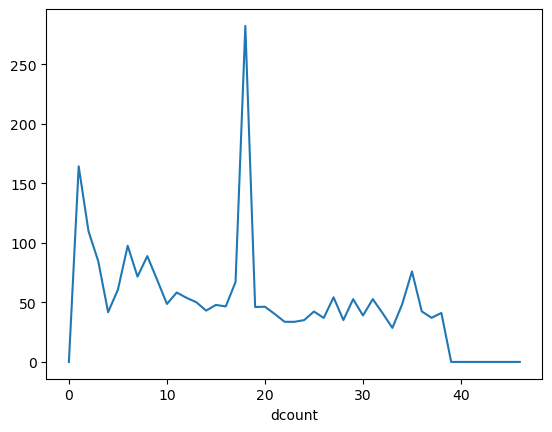

In [42]:
# set the lag value to 1
lag = 1  

# create a new column 'mbd_lag_1' with the shifted values of the 'microbusiness_density' column, forward-filled within each 'cfips' group
# 이 컬럼은 microbusiness_density 컬럼의 값을 lag만큼 이동시킨 결과가 저장된다.
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()

# create a new column 'dif' with the absolute difference between the current and lag 'microbusiness_density' values, normalized by the lag value
# 이 컬럼은 microbusiness_density 컬럼과 'mbd_lag_{lag}' 컬럼의 차이를 저장한다.
# 먼저 microbusiness_density 컬럼과 'mbd_lag_{lag}' 컬럼의 비율을 계산한 결과가 저장된다.
# 그리고 fillna() 함수를 사용해서 NaN 값을 1로 채운다. 그런 후에 clip() 함수를 사용해서 최솟값을 0으로 제한한뒤 -1을 한다.
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1

# set the 'dif' values to 0 where the lag 'microbusiness_density' is 0
# loc[] 속성을 사용해서 raw 데이터프레임에서 'mbd_lag_{lag}' 컬럼의 값이 0인 행과 inf인 행을 선택한다.
# 그리고 이 행의 'dif' 컬럼의 값을 0으로 설정한다.
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0

# set the 'dif' values to 1 where the current 'microbusiness_density' is positive and the lag 'microbusiness_density' is 0
# 'microbusiness_density' 컬럼의 값이 0보다 크고 'mbd_lag_{lag}' 컬럼의 값이 0인 행의 'dif' 컬럼의 값을 1로 설정한다.
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1

# take the absolute value of the 'dif' column
# raw 데이터프레임에서 'dif' 컬럼의 값을 절대값으로 변경한다.
raw['dif'] = raw['dif'].abs()

# plot the sum of the 'dif' values within each 'dcount' group
# groupby() 함수는 raw 데이터프레임을 'dcount' 컬럼 값을 기준으로 그룹화한다.
# 그룹화된 데이터프레임에서 'dif' 컬럼의 값을 전부 더한 결과를 시리즈로 생성한다.
# 이 시리즈를 plot() 함수로 그래프로 그힌다. 그래프의 x축은 'dcount' 컬럼의 값이고, y축은 'dif' 컬럼의 값의 합이 된다.
raw.groupby('dcount')['dif'].sum().plot()

In [43]:
raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,mbd_lag_1,dif
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,3.007682,0.000000
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,3.007682,0.040833
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,2.884870,0.059265
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0,3.055843,0.020489
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0,2.993233,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,42,3134,50,NaN,0.000000
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,43,3134,50,NaN,0.000000
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,44,3134,50,NaN,0.000000
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,45,3134,50,NaN,0.000000


## 이상치 제거

In [44]:
outliers = []  # initialize a list to store 'cfips' values with outliers
cnt = 0  # initialize a counter for the number of outliers

# loop through each 'cfips' value in the data
# tqdm()를 사용하면 코드가 얼마나 진행되었는지를 알 수 있게된다.
# 이 for문은 raw 데이터프레임에서 'cfips' 컬럼의 고유한 값을 o에 넣어준다.
for o in tqdm(raw.cfips.unique()):

    # get the indices for rows with the current 'cfips' value
    # 'cfips' 컬럼의 값이 현재 순회 중인 값과 같은 행은 raw[raw['cfips']==o] 으로도 선택이 가능하다.
    # 이 코드에서는 인덱스를 추출하기 위해 (raw['cfips']==o) boolean 시리즈를 생성한 후 인덱스를 추출하고 있다.
    indices = (raw['cfips']==o)
    
    # create a temporary copy of the data for the current 'cfips' value
    # 유니크(raw.cfips.unique()) 값에 해당하는 행들을 tep에 저장한다.
    tmp = raw.loc[indices].copy().reset_index(drop=True)
    
    # copy the 'microbusiness_density' values for the current 'cfips' value
    # tmp 데이터프레임에서 'microbusiness_density' 컬럼의 값들을 추출한 후, 이를 NumPy 배열로 변환하고 이를 복사한 값을 var 변수에 할당한다.
    var = tmp.microbusiness_density.values.copy()
    
    
    # loop through the values in reverse order, starting from index 37 and ending at index 2
    # 37부터 2까지 -1씩 감소하는 정수 시퀀스를 생성합니다. 즉, 37, 36, ... , 3, 2 순으로 정수가 생성
    for i in range(37, 2, -1):
    
        # calculate a threshold value as 20% of the mean of the first i values
        # var 변수의 앞쪽 i개의 값들의 평균을 계산한 후, 이 값의 20%를 thr 변수에 할당합니다.
        thr = 0.20*np.mean(var[:i])
        
        # calculate the absolute difference between the current and previous values
        # var 변수의 인덱스가 i-1인 값과 인덱스가 i인 값의 차이를 계산한 후, 이 값의 절대값을 difa 변수에 할당
        difa = abs(var[i]-var[i-1])
        
        
        # if the difference is greater than or equal to the threshold
        if (difa>=thr):
            # scale the first i values by the ratio of the current and previous values
            # var 변수의 인덱스가 0부터 i-1까지인 슬라이스에 (var[i]/var[i-1])의 값을 곱한 결과를 저장
            var[:i] *= (var[i]/var[i-1])
            
            # add the 'cfips' value to the list of outliers
            # outliers 리스트 변수에 o 변수의 값을 추가
            outliers.append(o)
            
            # increment the counter for the number of outliers
            # cnt 변수의 값을 1 증가
            cnt+=1
            
    
    # set the first value to be 99% of the second value
    # var 변수의 인덱스가 1인 값의 99%를 인덱스가 0인 값으로 할당
    var[0] = var[1]*0.99
  
    # update the 'microbusiness_density' values in the original data with the modified values for the current 'cfips' value
    # raw 데이터프레임에서 인덱스가 indices에 해당하는 값들의 'microbusiness_density' 컬럼을 var 변수의 값으로 설정
    raw.loc[indices, 'microbusiness_density'] = var
    
    
# get the unique values in the list of outliers and store it back in the 'outliers' variable
# 배열에서 고유한 값을 찾아 정렬된 배열로 반환
outliers = np.unique(outliers)


# print the number of unique 'cfips' values with outliers and the total number of outliers
# len(outliers)는 "outliers" 변수에 있는 요소의 개수를 반환하는 함수입니다. 
# 이것은 파이썬 내장 함수인 len() 함수와 동일합니다.
# cnt 변수는 코드에서 이전에 정의되었을 수 있으며 여기서 사용되고 있습니다.
# 이들 변수가 어떤 코드에서 사용되고 있는지, 그리고 그들이 가지고 있는 값을 알고 있다면 이 코드에서의 목적을 이해하는데 더욱 도움이 됩니다.
len(outliers), cnt

  0%|          | 0/3135 [00:00<?, ?it/s]

C:\Users\Taeyang\AppData\Local\Temp\ipykernel_11260\3253856476.py:40: RuntimeWarning: invalid value encountered in scalar divide
  var[:i] *= (var[i]/var[i-1])
C:\Users\Taeyang\AppData\Local\Temp\ipykernel_11260\3253856476.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  var[:i] *= (var[i]/var[i-1])
C:\Users\Taeyang\AppData\Local\Temp\ipykernel_11260\3253856476.py:40: RuntimeWarning: invalid value encountered in multiply
  var[:i] *= (var[i]/var[i-1])
C:\Users\Taeyang\AppData\Local\Temp\ipykernel_11260\3253856476.py:33: RuntimeWarning: invalid value encountered in scalar subtract
  difa = abs(var[i]-var[i-1])


(481, 732)

<AxesSubplot: xlabel='dcount'>

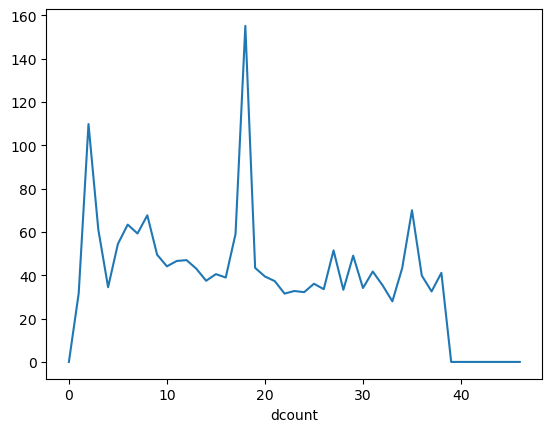

In [45]:
lag = 1

# Create a new column in the raw dataframe that is the microbusiness density value of the previous month
# (shifted by lag number of periods) for each cfips. Use backfill (bfill) to fill in the first value for
# each cfips with the value from the second row.
# "raw" 데이터프레임에 f'mbd_lag_[lag]' 열을 추가한다.
# 이 열에는 "microbusiness_density" 열이 배치되며, "cfips" 열로 그룹화되어있으며, "lag" 변수로 지정된 수만큼 이동되어 있으며, 누락된 값은 앞쪽에 있는 값으로 채워다.
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()


# Create a new column in the raw dataframe that is the difference between the current month's
# microbusiness density and the previous month's microbusiness density, as a percentage.
# Fill missing values with 1 and clip values between 0 and infinity.
# "raw" 데이터프레임의 새로운 열 "dif"는 현재와 이전 랙의 microbusiness_density 값의 상대적 차이를 가지고 있으며, 누락된 값은 1로 대체되고 1보다 큰 값은 1로 설정
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1


# Replace all 0 values in the new 'dif' column with 0.
# "mbd_lag_[lag]" 열이 0값인 경우 'dif' 열 값을 0으로 바꾸고 이를 통해 그 다음 계산에서 0으로 나누는 에러를 방지하기 위해 사용
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0


# Replace all values in the new 'dif' column that are positive and have a corresponding value of 0 in
# the previous month's 'microbusiness_density' column with 1.
# "microbusiness_density" 열이 0보다 크고 "mbd_lag_[lag]" 열이 0일때 'dif' 열 값을 1로 바꾸고 이를 통해 그 다음 계산에서 0으로 나누는 에러를 방지하고, 결과가 올바른 결과를 가지도록 하기 위해 사용
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1


# Take the absolute value of all values in the new 'dif' column.
# 'dif' 열의 절대값을 구하며, 음수값을 양수로 바꾸고 결과값은 양수 값만 가지도록 합니다.
raw['dif'] = raw['dif'].abs()


# Plot the sum of the 'dif' column for each value of 'dcount' (cumulative count of rows within each cfips).
# 'raw' 데이터프레임을 'dcount' 열로 그룹화 하여 그룹 당 'dif' 열의 합을 구하고, 그 결과를 그래프로 표시합니다. 그러면 그래프는 dcount 그룹별로 dif 열의 합이 어떻게 변화하는지 보여줍니다.
raw.groupby('dcount')['dif'].sum().plot()

<AxesSubplot: xlabel='dcount'>

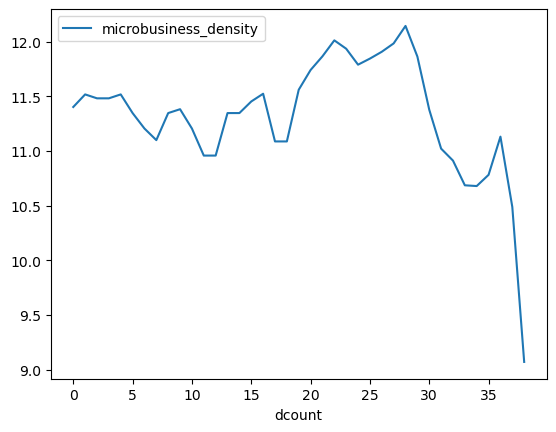

In [46]:
# cfips 값이 21215인 관측치의 dcount와 microbusiness_density 사이의 관계를 나타내는 그래프를 생성
raw.loc[raw.cfips == 21215].plot(x='dcount', y='microbusiness_density')

SMAPE is a relative metric so target must be converted <br>
SMAPE는 상대적인 측정 기준이므로 target이 변환되어야 한다.<br>
SMAPE는 Symmetric Mean Absolute Percentage Error의 약자로, 예측값과 실제 값 사이의 오차를 비율로 표현하는 측정 기준이다 <br>
때문에 target을 변환시켜야 한다.<br>

In [47]:
# Create a new column in the dataframe called 'target'
# "raw" 데이터프레임에 새로운 열 'target'을 생성한다. 
# 각 셀의 'target' 열 값은 'raw' 데이터프레임에서 'cfips' 열의 값으로 그룹화하여 행을 그룹화 한 다음 
# 'microbusiness_density' 열의 값을 shift(-1) 함수를 이용하여 한 칸 아래로 이동시킨 값을 가져와 target으로 설정한다.
raw['target'] = raw.groupby('cfips')['microbusiness_density'].shift(-1)

# Divide the shifted microbusiness density values by the original microbusiness density values and subtract 1
# 이전 단계에서 생성 된 새로운 'target' 열을 사용하여 이 열의 값을 raw 데이터프레임의 'microbusiness_density' 열의 값으로 나누고, 1을 결과에서 뺀다.
# 그렇게 하면 두 열 사이의 상대적 변화를 백분율 형식으로 얻을 수 있다.
raw['target'] = raw['target']/raw['microbusiness_density'] - 1

# Set the target value for rows with cfips value of 28055 to 0
# "raw" 데이터프레임에서 .loc 접근자를 사용하여 "cfips" 열의 값이 28055인 행만 필터링 한다. 
# 그리고 이 행들의 'target' 열을 0.0 으로 설정한다. 
# 이 코드는 특정 관측 그룹의 target 값을 0으로 설정하는데, 이 경우 'cfips' 가 28055인 관측 그룹을 의미합니다. 
# 이 그룹의 관측 결과는 변동이나 오류로 인해 제거
raw.loc[raw['cfips']==28055, 'target'] = 0.0

# Set the target value for rows with cfips value of 48269 to 0
raw.loc[raw['cfips']==48269, 'target'] = 0.0

# Display the last 20 rows and the first 20 columns of the dataframe
# 첫번째 파라미터 -20 은 데이터프레임의 마지막 20행을 선택하고 두번째 파라미터 :20은 데이터프레임의 첫번째 20열을 선택합니다.
raw.iloc[-20:,:20]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,mbd_lag_1,dif,target
147325,56045_2021-11-01,56045,Weston County,Wyoming,2021-11-01,1.760374,98.0,0,2021,11,27,3134,50,1.670559,0.053763,0.020408
147326,56045_2021-12-01,56045,Weston County,Wyoming,2021-12-01,1.796300,100.0,0,2021,12,28,3134,50,1.760374,0.020408,-0.025949
147327,56045_2022-01-01,56045,Weston County,Wyoming,2022-01-01,1.749688,98.0,0,2022,1,29,3134,50,1.796300,0.025949,0.000000
147328,56045_2022-02-01,56045,Weston County,Wyoming,2022-02-01,1.749688,98.0,0,2022,2,30,3134,50,1.749688,0.000000,0.010204
147329,56045_2022-03-01,56045,Weston County,Wyoming,2022-03-01,1.767542,99.0,0,2022,3,31,3134,50,1.749688,0.010204,0.000000
147330,56045_2022-04-01,56045,Weston County,Wyoming,2022-04-01,1.767542,99.0,0,2022,4,32,3134,50,1.767542,0.000000,0.020202
147331,56045_2022-05-01,56045,Weston County,Wyoming,2022-05-01,1.803249,101.0,0,2022,5,33,3134,50,1.767542,0.020202,0.000000
147332,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101.0,0,2022,6,34,3134,50,1.803249,0.000000,0.000000
147333,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101.0,0,2022,7,35,3134,50,1.803249,0.000000,-0.009901
147334,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100.0,0,2022,8,36,3134,50,1.803249,0.009901,0.000000


<AxesSubplot: >

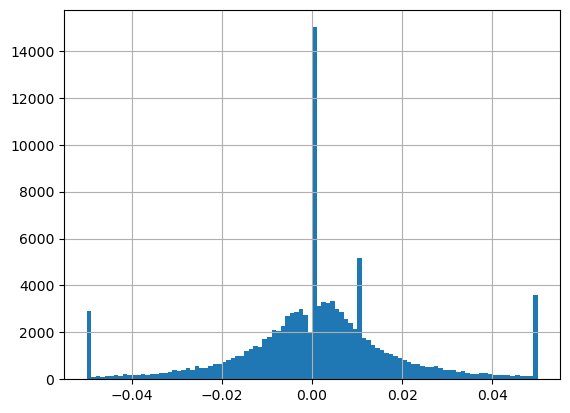

In [48]:
# 첫째로 'raw' 데이터프레임의 'target' 열을 대괄호 표기법으로 선택하고, 
# 그다음에는 이 열에 'clip()' 메소드를 적용하여 'target' 열의 값 범위를 -0.05와 0.05 사이로 제한합니다.
# 그리고 hist() 메소드를 이용해 수정된 'target' 열의 히스토그램을 그립니다. 
# 이 히스토그램은 'target' 열의 분포를 나타내기 위해 100개의 bins를 사용합니다.
raw['target'].clip(-0.05, 0.05).hist(bins=100)

<AxesSubplot: >

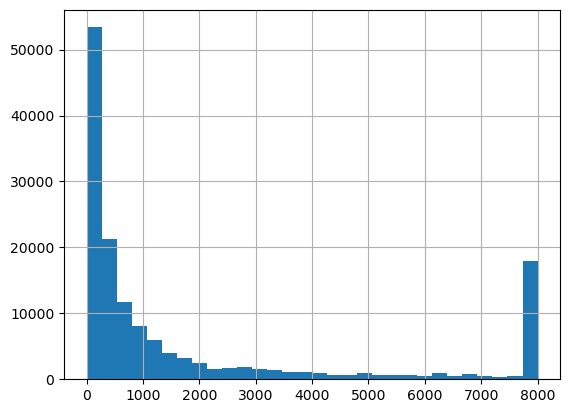

In [49]:
# Create a new column in the dataframe called 'lastactive'
# by grouping the dataframe by the 'cfips' column and applying the 'last()' function to the 'active' column
# 'cfips' 그룹 단위로 'active' 컬럼의 마지막 값을 캡처하는 새로운 컬럼을 생성하는데 사용되며, 현재 active 상태와 이전 active 상태를 비교하는 분석에 유용할 수 있다.
raw['lastactive'] = raw.groupby('cfips')['active'].transform('last')


# Select rows from the dataframe where the 'dcount' column is equal to 28
# and group the resulting dataframe by the 'cfips' column
# Apply the 'last()' function to the 'microbusiness_density' column and store the resulting Series in 'dt'
# 'dt' 라는 새로운 변수를 생성합니다. 
# 그리고 loc 접근자를 사용하여 'raw' 데이터프레임에서 'dcount' 열의 값이 28 인 행만 필터링 합니다. 
# 그리고 이 필터링된 행들을 'cfips' 열의 값에 따라 그룹화하고, 
# 'microbusiness_density' 열에 'last' 라는 인수를 가진 'agg()' 메서드를 적용하여 각 'cfips' 그룹의 'microbusiness_density' 열의 마지막 값을 얻는다.
dt = raw.loc[raw.dcount==28].groupby('cfips')['microbusiness_density'].agg('last')

# Create a new column in the dataframe called 'lasttarget' by mapping the 'cfips' column to the 'dt' Series
# cfips 열을 dt 사전에 매핑하는 lasttarget이라는 새 열을 생성합니다.
raw['lasttarget'] = raw['cfips'].map(dt)

# Create a histogram of the 'lastactive' column in the dataframe, with the values in the 'lastactive' column being limited to the range 0 to 8000
raw['lastactive'].clip(0, 8000).hist(bins=30)

## Feature Engineering

In [50]:
def build_features(raw, target='microbusiness_density', target_act='active_tmp', lags = 6):
    feats = []
    for lag in range(1, lags):
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')
        
    lag = 1
    for window in [2, 4, 6]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())        
        #raw[f'mbd_rollmea{window}_{lag}'] = raw[f'mbd_lag_{lag}'] - raw[f'mbd_rollmea{window}_{lag}']
        feats.append(f'mbd_rollmea{window}_{lag}')
        
    return raw, feats

In [51]:
# Build Features based in lag of target
raw, feats = build_features(raw, 'target', 'active', lags = 4)
features = ['state_i']
features += feats
print(features)
raw.loc[raw.dcount==38, features].head(10)

['state_i', 'mbd_lag_1', 'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_rollmea2_1', 'mbd_rollmea4_1', 'mbd_rollmea6_1']


,state_i,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_rollmea2_1,mbd_rollmea4_1,mbd_rollmea6_1
38,0,0.006152,9.0,0.005498,17.0,-0.004107,11.0,0.011650,0.034969,0.027467
85,0,0.002170,31.0,-0.017601,-225.0,-0.009601,-366.0,-0.015431,-0.017278,0.049618
132,0,0.020921,5.0,0.008439,7.0,-0.016597,3.0,0.029359,0.033948,0.033966
179,0,-0.021367,-5.0,0.017391,-1.0,-0.025424,-7.0,-0.003976,0.010248,0.028286
226,0,-0.010949,-9.0,0.008589,-2.0,0.002460,0.0,-0.002360,0.033137,0.038372
273,0,0.012987,1.0,0.013158,2.0,0.013333,3.0,0.026145,0.052992,0.080770
320,0,0.009036,3.0,0.027864,12.0,0.031949,22.0,0.036900,0.098454,0.171279
367,0,-0.003180,-8.0,0.007609,11.0,0.002006,16.0,0.004429,0.027747,0.034010
414,0,-0.040201,-16.0,-0.012407,-21.0,-0.017073,-28.0,-0.052608,-0.015697,-0.023285
461,0,-0.012605,-3.0,0.000000,-3.0,-0.008333,-5.0,-0.012605,0.000338,-0.098884


<AxesSubplot: >

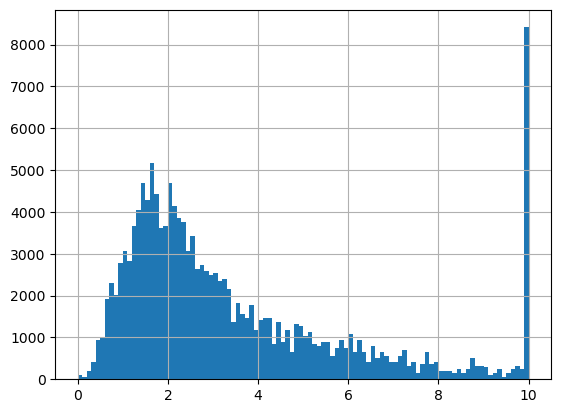

In [52]:
raw['lasttarget'].clip(0,10).hist(bins=100)

In [53]:
import xgboost as xgb

blacklist = [
    'North Dakota', 'Iowa', 'Kansas', 'Nebraska', 'South Dakota','New Mexico', 'Alaska', 'Vermont'
]
blacklistcfips = [
1019,1027,1029,1035,1039,1045,1049,1057,1067,1071,1077,1085,1091,1099,1101,1123,1131,1133,4001,4012,4013,4021,4023,5001,5003,5005,5017,5019,5027,5031,5035,5047,5063,5065,5071,5081,5083,5087,5091,5093,5107,5109,5115,5121,5137,5139,5141,5147,6003,6015,6027,6033,6053,6055,6057,6071,6093,6097,6103,6105,6115,8003,8007,8009,8019,8021,8023,8047,8051,8053,8055,8057,8059,8061,8065,8067,8069,8071,8073,8075,8085,8091,8093,8097,8099,8103,8105,8107,8109,8111,8115,8117,8121,9007,9009,9015,12009,12017,12019,12029,12047,12055,12065,12075,12093,12107,12127,13005,13007,13015,13017,13019,13027,13035,13047,13065,13081,13083,13099,13107,13109,13117,13119,13121,13123,13125,13127,13135,13143,13147,13161,13165,13171,13175,13181,13193,13201,13221,13225,13229,13231,13233,13245,13247,13249,13257,13279,13281,13287,13289,13293,13301,13319,15001,15005,15007,16001,16003,16005,16007,16013,16015,16017,16023,16025,16029,16031,16033,16035,16037,16043,16045,16049,16061,16063,16067,17001,17003,17007,17009,17013,17015,17023,17025,17031,17035,17045,17051,17059,17061,17063,17065,17067,17069,17075,17077,17081,17085,17087,17103,17105,17107,17109,17115,17117,17123,17127,17133,17137,17141,17143,17147,17153,17167,17169,17171,17177,17179,17181,17185,17187,17193,18001,18007,18009,18013,18015,18019,18021,18025,18035,18037,18039,18041,18053,18061,18075,18079,18083,18087,18099,18103,18111,18113,18115,18137,18139,18145,18153,18171,18179,21001,21003,21013,21017,21023,21029,21035,21037,21039,21045,21047,21055,21059,21065,21075,21077,21085,21091,21093,21097,21099,21101,21103,21115,21125,21137,21139,21141,21149,21155,21157,21161,21165,21179,21183,21191,21197,21199,21215,21217,21223,21227,21237,21239,22019,22021,22031,22039,22041,22047,22069,22085,22089,22101,22103,22109,22111,22115,22119,22121,23003,23009,23021,23027,23029,24011,24027,24029,24031,24035,24037,24039,24041,25011,25015,26003,26007,26011,26019,26021,26025,26027,26033,26037,26041,26043,26051,26053,26057,26059,26061,26065,26071,26077,26079,26083,26089,26097,26101,26103,26109,26111,26115,26117,26119,26127,26129,26131,26135,26141,26143,26155,26161,26165,27005,27011,27013,27015,27017,27021,27023,27025,27029,27047,27051,27055,27057,27065,27069,27073,27075,27077,27079,27087,27091,27095,27101,27103,27105,27107,27109,27113,27117,27119,27123,27125,27129,27131,27133,27135,27141,27147,27149,27155,27159,27167,27169,28017,28019,28023,28025,28035,28045,28049,28061,28063,28093,28097,28099,28125,28137,28139,28147,28159,29001,29015,29019,29031,29033,29041,29049,29051,29055,29057,29063,29065,29069,29075,29085,29089,29101,29103,29111,29121,29123,29125,29135,29137,29139,29143,29157,29159,29161,29167,29171,29173,29175,29177,29183,29195,29197,29199,29203,29205,29207,29209,29213,29215,29217,29223,29227,29229,30005,30009,30025,30027,30033,30035,30037,30039,30045,30049,30051,30053,30055,30057,30059,30069,30071,30073,30077,30079,30083,30085,30089,30091,30093,30101,30103,30105,30107,30109,32005,32009,32017,32023,32027,32029,32510,33005,33007,34021,34027,34033,34035,36011,36017,36023,36033,36043,36047,36049,36051,36057,36061,36067,36083,36091,36097,36103,36107,36113,36115,36121,36123,37005,37009,37011,37017,37023,37029,37031,37049,37061,37075,37095,37117,37123,37131,37137,37151,37187,37189,37197,39005,39009,39015,39017,39019,39023,39037,39039,39043,39049,39053,39057,39063,39067,39071,39077,39085,39087,39091,39097,39105,39107,39113,39117,39119,39125,39127,39129,39135,39137,39151,39153,39157,40003,40013,40015,40023,40025,40027,40035,40039,40043,40045,40053,40055,40057,40059,40065,40067,40073,40077,40079,40099,40105,40107,40111,40115,40123,40127,40129,40133,40141,40147,40151,40153,41001,41007,41013,41015,41017,41021,41025,41031,41033,41037,41051,41055,41063,41067,41069,42005,42007,42011,42013,42015,42019,42027,42029,42031,42035,42053,42057,42067,42071,42083,42085,42093,42097,42105,42111,42113,42115,42123,42125,42127,42129,44005,44007,44009,45001,45009,45021,45025,45031,45059,45067,45071,45073,45089,47001,47005,47013,47015,47019,47021,47023,47027,47035,47039,47041,47047,47055,47057,47059,47061,47069,47073,47075,47077,47083,47087,47099,47105,47121,47127,47131,47133,47135,47137,47147,47151,47153,47159,47161,47163,47169,47177,47183,47185,48001,48011,48017,48019,48045,48057,48059,48063,48065,48073,48077,48079,48081,48083,48087,48095,48101,48103,48107,48109,48115,48117,48119,48123,48125,48129,48149,48151,48153,48155,48159,48161,48165,48175,48189,48191,48195,48197,48211,48221,48229,48233,48235,48237,48239,48241,48243,48245,48255,48261,48263,48265,48267,48269,48275,48277,48283,48293,48299,48305,48311,48313,48319,48321,48323,48327,48333,48345,48347,48355,48369,48377,48379,48383,48387,48389,48401,48403,48413,48417,48431,48433,48437,48443,48447,48453,48455,48457,48461,48463,48465,48469,48471,48481,48483,48485,48487,48495,48499,49001,49009,49013,49019,49027,49031,49045,51005,51017,51025,51029,51031,51036,51037,51043,51057,51059,51065,51071,51073,51077,51079,51083,51091,51095,51097,51101,51111,51115,51119,51121,51127,51135,51147,51155,51159,51165,51167,51171,51173,51181,51183,51191,51197,51530,51590,51610,51620,51670,51678,51720,51735,51750,51770,51810,51820,53013,53019,53023,53031,53033,53037,53039,53041,53047,53065,53069,53071,53075,54013,54019,54025,54031,54033,54041,54049,54055,54057,54063,54067,54071,54077,54079,54085,54089,54103,55001,55003,55005,55007,55011,55017,55021,55025,55029,55037,55043,55047,55049,55051,55061,55065,55067,55075,55077,55091,55097,55101,55103,55109,55117,55123,55125,55127,56007,56009,56011,56015,56017,56019,56021,56027,56031,56037,56043,56045,
12061,  6095, 49025, 18073, 29029, 29097, 48419, 51830, 30067, 26095, 18159, 32001, 54065, 54027, 13043, 48177, 55069, 48137, 30087, 29007, 13055, 48295, 28157, 29037, 45061, 22053, 13199, 47171, 53001, 55041, 51195, 18127, 29151, 48307, 51009, 16047, 29133,  5145, 17175, 21027, 48357, 29179, 13023, 16077, 48371, 21057, 16039, 21143, 48435, 48317, 48475,  5129, 36041, 48075, 29017, 47175, 39167, 47109, 17189, 17173, 28009, 39027, 48133, 18129, 48217, 40081, 36021,  6005, 42099, 18051, 36055, 53051, 6109, 21073, 27019,  6051, 48055,  8083, 48503, 17021, 10003, 41061, 22001, 22011, 21205, 48223, 51103, 51047, 16069, 17033, 41011,  6035, 47145, 27083, 18165, 36055, 12001, 26159,  8125, 34017,
28141, 55119, 48405, 40029, 18125, 21135, 29073, 55115, 37149,55039, 26029, 12099, 13251, 48421, 39007, 41043, 22015, 37115,54099, 51137, 22049, 55131, 17159, 56001, 40005, 18017, 28091,47101, 27037, 29005, 13239, 21019, 55085, 48253, 51139, 40101,13283, 18049, 39163, 45049, 51113,
]
ACT_THR = 1.8
ABS_THR = 1.00
raw['ypred_last'] = np.nan
raw['ypred'] = np.nan
raw['k'] = 1.
VAL = []
BEST_ROUNDS = []
for TS in range(29, 38):
    print(TS)
    
    model = xgb.XGBRegressor(
        objective='reg:pseudohubererror', # 작동하지 않을경우 xgboost를 1.7.3버젼으로 업데이트 하거나 'reg:squarederror' 사용
        # objective='reg:squarederror',
        tree_method="hist",
        n_estimators=4999,
        learning_rate=0.0075,
        max_leaves = 17,
        subsample=0.50,
        colsample_bytree=0.50,
        max_bin=4096,
        n_jobs=2,
        eval_metric='mae',
        early_stopping_rounds=70,
    )
            
    train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR)  & (raw.lasttarget>ABS_THR) 
    valid_indices = (raw.istest==0) & (raw.dcount == TS)

    model.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.0043, 0.0045),
        eval_set=[(raw.loc[valid_indices, features], raw.loc[valid_indices, 'target'])],
        verbose=500,
    )
    
    best_rounds = model.best_iteration
    BEST_ROUNDS.append(model.best_iteration) 

    # model.best_iteration이 작동하지 않으면 ntree_limit으로 수정
    # best_rounds = model.best_ntree_limit 
    # BEST_ROUNDS.append(model.best_ntree_limit)
    
    ypred = model.predict(raw.loc[valid_indices, features])
    raw.loc[valid_indices, 'k'] = ypred + 1
    raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

    # Validate
    lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
    dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']
    
    df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
    df['pred'] = df['cfips'].map(dt)
    df['lastval'] = df['cfips'].map(lastval)
    
    df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
    df.loc[df['lastval']<=ABS_THR, 'pred'] = df.loc[df['lastval']<=ABS_THR, 'lastval']
    df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
    df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips), 'lastval']
    raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
    raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values
    
    print(f'TS: {TS}')
    print('Last Value SMAPE:', smape(df['microbusiness_density'], df['lastval']) )
    print('XGB SMAPE:', smape(df['microbusiness_density'], df['pred']))
    print()


ind = (raw.dcount>=30)&(raw.dcount<=38)
print( 'XGB SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred'] ) )
print( 'Last Value SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred_last'] ) )

29
[0]	validation_0-mae:0.49351
[500]	validation_0-mae:0.01429
[899]	validation_0-mae:0.01090
TS: 29
Last Value SMAPE: 1.0868726017655663
XGB SMAPE: 1.073535721469521

30
[0]	validation_0-mae:0.48746
[500]	validation_0-mae:0.01257
[641]	validation_0-mae:0.01206
TS: 30
Last Value SMAPE: 1.318087470449913
XGB SMAPE: 1.147644258242453

31
[0]	validation_0-mae:0.49315
[500]	validation_0-mae:0.01466
[927]	validation_0-mae:0.01118
TS: 31
Last Value SMAPE: 1.1258309832479911
XGB SMAPE: 1.1057161563696658

32
[0]	validation_0-mae:0.49995
[500]	validation_0-mae:0.01701
[1000]	validation_0-mae:0.00927
[1500]	validation_0-mae:0.00912
[2000]	validation_0-mae:0.00910
[2487]	validation_0-mae:0.00910
TS: 32
Last Value SMAPE: 0.897969439640235
XGB SMAPE: 0.9068117106812955

33
[0]	validation_0-mae:0.48932
[500]	validation_0-mae:0.01449
[680]	validation_0-mae:0.01329
TS: 33
Last Value SMAPE: 1.3686285670946152
XGB SMAPE: 1.2610648169396423

34
[0]	validation_0-mae:0.47751
[500]	validation_0-mae:0.01611

In [54]:
raw['error'] = vsmape(raw['microbusiness_density'], raw['ypred'])
raw['error_last'] = vsmape(raw['microbusiness_density'], raw['ypred_last'])
raw.loc[(raw.dcount==30), ['microbusiness_density', 'ypred', 'error', 'error_last'] ]

,microbusiness_density,ypred,error,error_last
30,3.334431,3.301176,1.002326,1.135557
77,7.823300,7.738163,1.094199,1.155810
124,1.206827,1.187824,1.587082,1.687769
171,1.236650,1.215900,1.692132,1.834867
218,1.777708,1.754257,1.327900,1.403959
...,...,...,...,...
147140,2.892446,2.926768,1.179620,1.179620
147187,25.438322,25.554117,0.454165,0.368550
147234,3.954258,3.757706,5.097314,5.183206
147281,3.027295,3.027295,0.000000,0.000000


In [55]:
dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby(['cfips','dcount'])['error', 'error_last'].last()
dt['miss'] = dt['error'] > dt['error_last']
dt = dt.groupby('cfips')['miss'].mean()
dt = dt.loc[dt>=0.50]
dt.shape

C:\Users\Taeyang\AppData\Local\Temp\ipykernel_11260\956906285.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby(['cfips','dcount'])['error', 'error_last'].last()


(18,)

In [56]:
len(dt.index)

18

In [57]:
','.join([str(i) for i in dt.index])

'5097,6021,6081,13213,17149,17155,25007,28115,30041,36101,37193,45023,47011,48361,53057,54083,54107,55045'

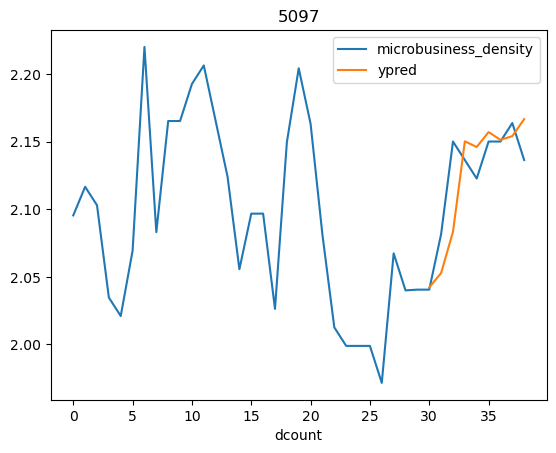

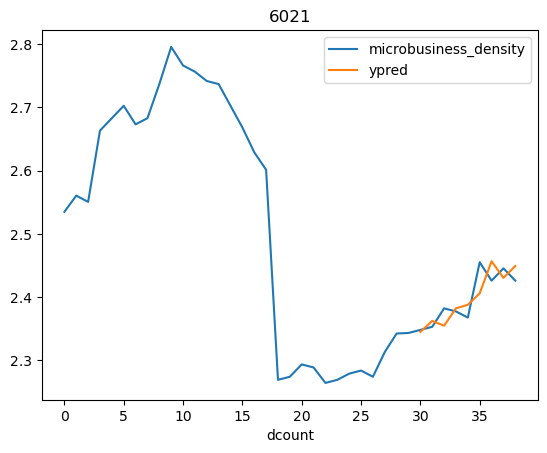

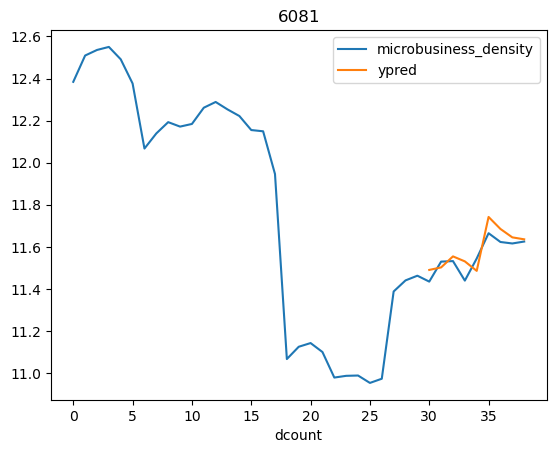

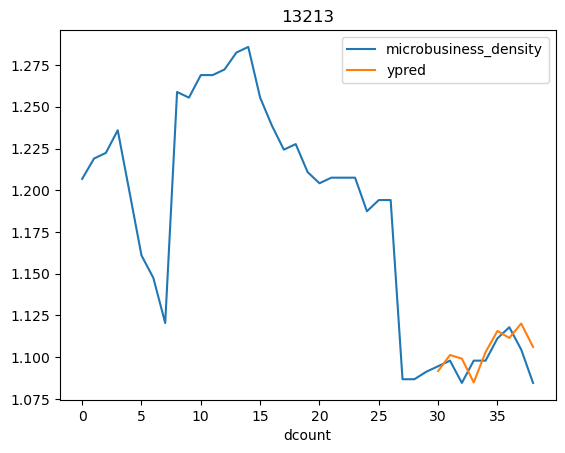

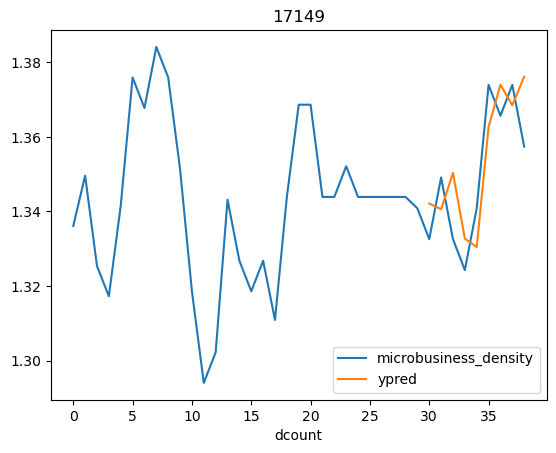

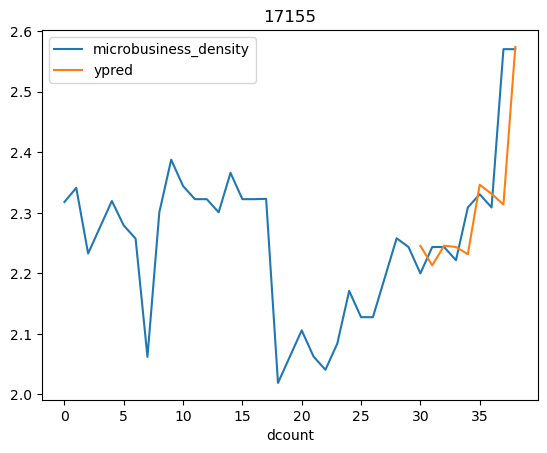

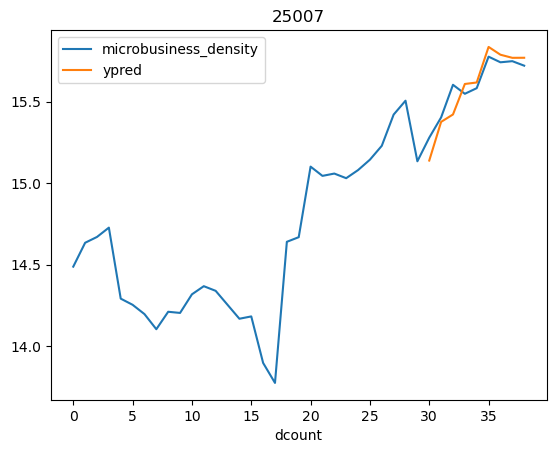

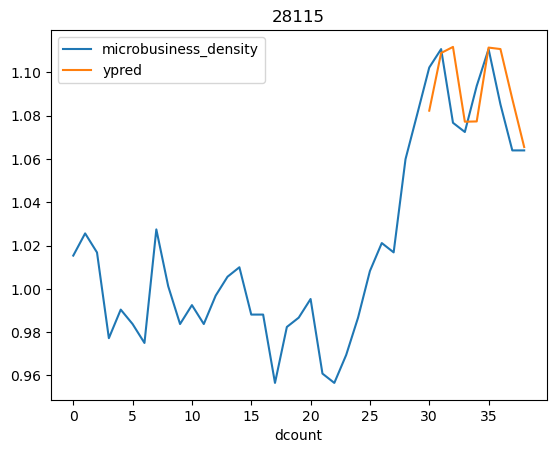

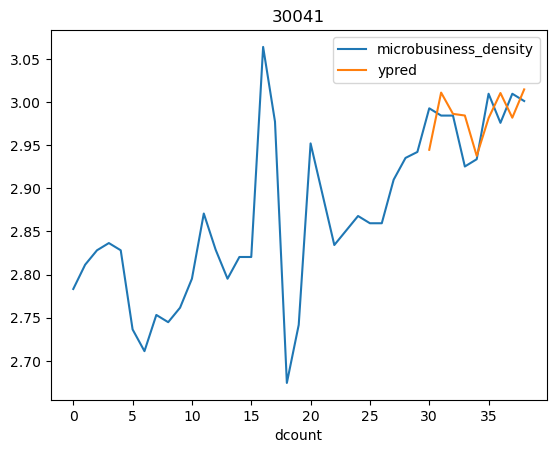

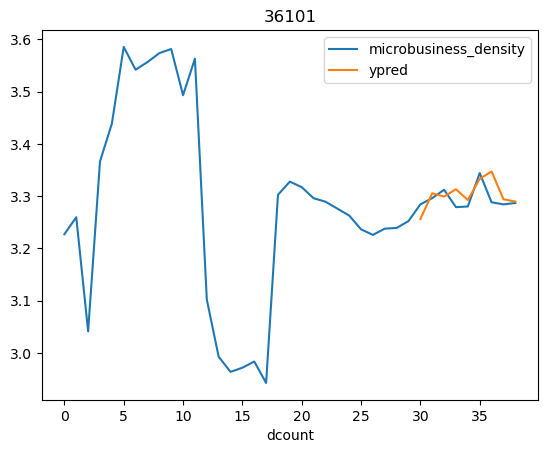

In [58]:
for d in dt.index[:10]:
    raw.loc[raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred'], title=str(d))

In [59]:
raw.iloc[-40:, :16]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,mbd_lag_1,dif,target
147305,56045_2020-03-01,56045,Weston County,Wyoming,2020-03-01,1.537087,86.0,0,2020,3,7,3134,50,0.011765,0.011765,0.011628
147306,56045_2020-04-01,56045,Weston County,Wyoming,2020-04-01,1.554960,87.0,0,2020,4,8,3134,50,0.011628,0.011628,0.034483
147307,56045_2020-05-01,56045,Weston County,Wyoming,2020-05-01,1.608579,90.0,0,2020,5,9,3134,50,0.034483,0.034483,0.033333
147308,56045_2020-06-01,56045,Weston County,Wyoming,2020-06-01,1.662198,93.0,0,2020,6,10,3134,50,0.033333,0.033333,-0.064516
147309,56045_2020-07-01,56045,Weston County,Wyoming,2020-07-01,1.554960,87.0,0,2020,7,11,3134,50,-0.064516,0.064516,0.022989
147310,56045_2020-08-01,56045,Weston County,Wyoming,2020-08-01,1.590706,89.0,0,2020,8,12,3134,50,0.022989,0.022989,0.000000
147311,56045_2020-09-01,56045,Weston County,Wyoming,2020-09-01,1.590706,89.0,0,2020,9,13,3134,50,0.000000,0.000000,-0.022472
147312,56045_2020-10-01,56045,Weston County,Wyoming,2020-10-01,1.554960,87.0,0,2020,10,14,3134,50,-0.022472,0.022472,0.000000
147313,56045_2020-11-01,56045,Weston County,Wyoming,2020-11-01,1.554960,87.0,0,2020,11,15,3134,50,0.000000,0.000000,0.011494
147314,56045_2020-12-01,56045,Weston County,Wyoming,2020-12-01,1.572833,88.0,0,2020,12,16,3134,50,0.011494,0.011494,0.016450


In [60]:
np.mean( BEST_ROUNDS ), np.median( BEST_ROUNDS ), BEST_ROUNDS

(970.0, 798.0, [830, 572, 857, 2418, 610, 441, 1479, 725, 798])

In [61]:
best_rounds = int(np.median( BEST_ROUNDS )+1)
best_rounds

799

In [62]:
TS = 38
print(TS)

model0 = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    #objective='reg:squarederror',
    tree_method="hist",
    n_estimators=best_rounds,
    learning_rate=0.0075,
    max_leaves = 31,
    subsample=0.60,
    colsample_bytree=0.50,
    max_bin=4096,
    n_jobs=2,
    eval_metric='mae',
)
model1 = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    #objective='reg:squarederror',
    tree_method="hist",
    n_estimators=best_rounds,
    learning_rate=0.0075,
    max_leaves = 31,
    subsample=0.60,
    colsample_bytree=0.50,
    max_bin=4096,
    n_jobs=2,
    eval_metric='mae',
)

train_indices = (raw.istest==0) & (raw.dcount < TS) & (raw.dcount >= 1) & (raw.lastactive > ACT_THR) & (raw.lasttarget > ABS_THR) 
valid_indices = (raw.dcount == TS)
model0.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.0044, 0.0046),
)
model1.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.0044, 0.0046),
)

ypred = (model0.predict(raw.loc[valid_indices, features]) + model1.predict(raw.loc[valid_indices, features]))/2
raw.loc[valid_indices, 'k'] = ypred + 1.
raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

# Validate
lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']

38


In [63]:
df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
df['pred'] = df['cfips'].map(dt)
df['lastval'] = df['cfips'].map(lastval)

df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
df.loc[df['lastval']<=ABS_THR, 'pred'] = df.loc[df['lastval']<=ABS_THR, 'lastval']
df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips), 'lastval']
raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values

In [64]:
raw[['cfips','microbusiness_density','dcount','ypred','ypred_last','k']].tail(20)

,cfips,microbusiness_density,dcount,ypred,ypred_last,k
147325,56045,1.760374,27,NaN,NaN,1.000000
147326,56045,1.796300,28,NaN,NaN,1.000000
147327,56045,1.749688,29,NaN,NaN,1.751144
147328,56045,1.749688,30,1.749688,1.749688,1.760278
147329,56045,1.767542,31,1.749688,1.749688,1.768961
147330,56045,1.767542,32,1.767542,1.767542,1.767344
147331,56045,1.803249,33,1.767542,1.767542,1.811541
147332,56045,1.803249,34,1.803249,1.803249,1.832507
147333,56045,1.803249,35,1.803249,1.803249,1.803691
147334,56045,1.785395,36,1.803249,1.803249,1.788847


# 테스트셋으로 예측한후 내보내기

In [65]:
raw.loc[raw['cfips']==28055, 'microbusiness_density'] = 0
raw.loc[raw['cfips']==48269, 'microbusiness_density'] = 1.762115

dt = raw.loc[raw.dcount==39, ['cfips', 'ypred']].set_index('cfips').to_dict()['ypred']
test = raw.loc[raw.istest==1, ['row_id', 'cfips','microbusiness_density']].copy()
test['microbusiness_density'] = test['cfips'].map(dt)

# test[['row_id','microbusiness_density']].to_csv('submission.csv', index=False)
# test.head(40)

## 모델 내보내기

In [67]:
import pickle
import datetime

# Get the current time in the UTC+9 timezone
now_utc_9 = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))

# Format the datetime object as a string
utc_9_time_str = now_utc_9.strftime('%Y-%m-%d-%H-%M-%S')

model_name = f'GoDaddy_model_{utc_9_time_str}.pkl'
with open(model_name,'wb') as pickle_file:
    pickle.dump(model, pickle_file)

# files.download(model_name)

## submission파일 내컴퓨터로 내보내기

In [68]:
import pickle
import datetime

# Get the current time in the UTC+9 timezone
now_utc_9 = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))

# Format the datetime object as a string
utc_9_time_str = now_utc_9.strftime('%Y-%m-%d-%H-%M-%S')

##################################################
raw.loc[raw['cfips']==28055, 'microbusiness_density'] = 0
raw.loc[raw['cfips']==48269, 'microbusiness_density'] = 1.762115

dt = raw.loc[raw.dcount==39, ['cfips', 'ypred']].set_index('cfips').to_dict()['ypred']
test = raw.loc[raw.istest==1, ['row_id', 'cfips','microbusiness_density']].copy()
test['microbusiness_density'] = test['cfips'].map(dt)
##################################################

file_name = f"GoDaddy_submission_{utc_9_time_str}.csv"
test[['row_id','microbusiness_density']].to_csv(file_name, index=False)
# files.download(file_name)

In [69]:
test.head(40)

,row_id,cfips,microbusiness_density
39,1001_2022-11-01,1001,3.468055
40,1001_2022-12-01,1001,3.468055
41,1001_2023-01-01,1001,3.468055
42,1001_2023-02-01,1001,3.468055
43,1001_2023-03-01,1001,3.468055
44,1001_2023-04-01,1001,3.468055
45,1001_2023-05-01,1001,3.468055
46,1001_2023-06-01,1001,3.468055
86,1003_2022-11-01,1003,8.379396
87,1003_2022-12-01,1003,8.379396


---